In [1]:
# trying to create some sort of new learning rate scheduler that can adapt

In [2]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [3]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [4]:

def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [5]:
def get_uncompiled_model(model_name, model_params_dict):
    assert model_name in ['resnet', 'mscalev2', 'mscalev1', 'mscalev3']

    if model_name == 'resnet':
        model = wispy.resnet.ResNet(**model_params_dict)
    elif model_name == 'mscalev2':
        model = wispy.mscalev2.build_model(**model_params_dict)
    elif model_name == 'mscalev1':
        model = pugna.models.mscalednn.build_model_2(**model_params_dict)
    elif model_name == 'mscalev3':
        model = wispy.mscalev3.build_model(**model_params_dict)

    return model


def get_compiled_model(model_name, model_params_dict, extra_params_dict):
    model = get_uncompiled_model(
        model_name=model_name, model_params_dict=model_params_dict)

    optimizer = tf.keras.optimizers.Adam(
        extra_params_dict['lr'], amsgrad=extra_params_dict['amsgrad'])

    model.compile(loss=extra_params_dict['loss'],
                  optimizer=optimizer, metrics=extra_params_dict['metrics'])

    return model

# load data

In [26]:
X_train = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy') #[:1500]
y_train = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy') #[:1500]

X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy') #[:1500]
y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy') #[:1500]

In [27]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

X_train.shape: (11190, 10)
y_train.shape: (11190, 1)
X_val.shape: (2238, 10)
y_val.shape: (2238, 1)


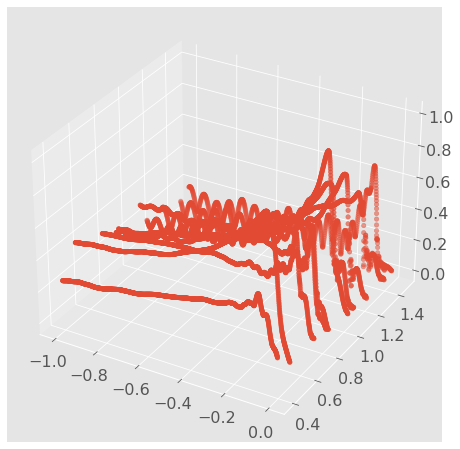

In [28]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,3], y_train[:,0])

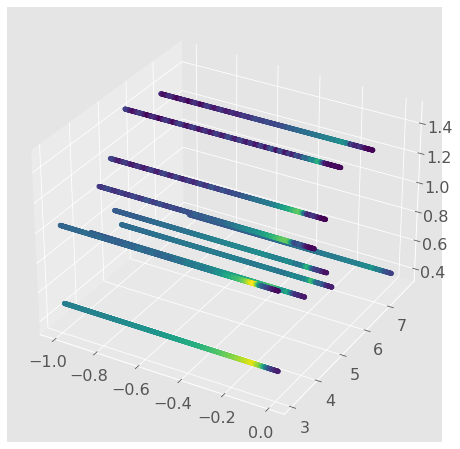

In [29]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,3], c=y_train[:,0])

# mscalev3 - scale time dim only

In [30]:
import tensorflow as tf
import wispy.mscalev3

In [31]:
epochs = 5000
batch_size = X_train.shape[0]
# batch_size = 32
print(f"batch_size: {batch_size}")

model_name = "mscalev3"

model_params_dict = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units = [128, 128],
    activation = "s2relu",
    n_blocks = [1,1],
    scales = [1,10],
    layers_per_block = 2,
    scale_dimension = 0,
    dtype = np.float32
)
extra_params_dict = dict(
    loss = 'mae',
    metrics = ['mse'],
    lr = 1e-3,
    amsgrad = False
)

verbose=0
# callbacks=None
callbacks=[pugna.callbacks.PrintDot()]
sample_weight=None

model_v3 = get_compiled_model(
    model_name=model_name,
    model_params_dict=model_params_dict,
    extra_params_dict=extra_params_dict)

batch_size: 11190


In [32]:
model_v3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
scale_layer_2 (ScaleLayer)      (None, 10)           0           input_2[0][0]                    
__________________________________________________________________________________________________
scale_layer_3 (ScaleLayer)      (None, 10)           0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          1408        scale_layer_2[0][0]              
____________________________________________________________________________________________

In [33]:
print("starting fit")
starttime = datetime.datetime.now()
history_v3 = model_v3.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=verbose
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................

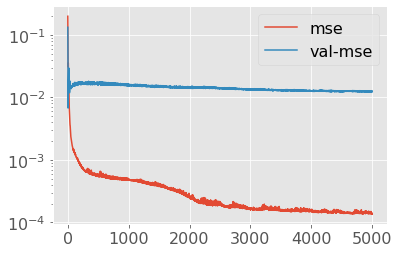

In [34]:
plt.figure()
plt.plot(history_v3.history['mse'], label='mse')
plt.plot(history_v3.history['val_mse'], label='val-mse')
plt.yscale('log')
plt.legend()

In [35]:
yhat_v3 = model_v3.predict(X_train)

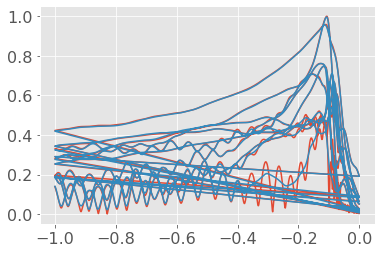

In [36]:
plt.figure()
plt.plot(X_train[:,0], y_train[:,0])
plt.plot(X_train[:,0], yhat_v3[:,0])

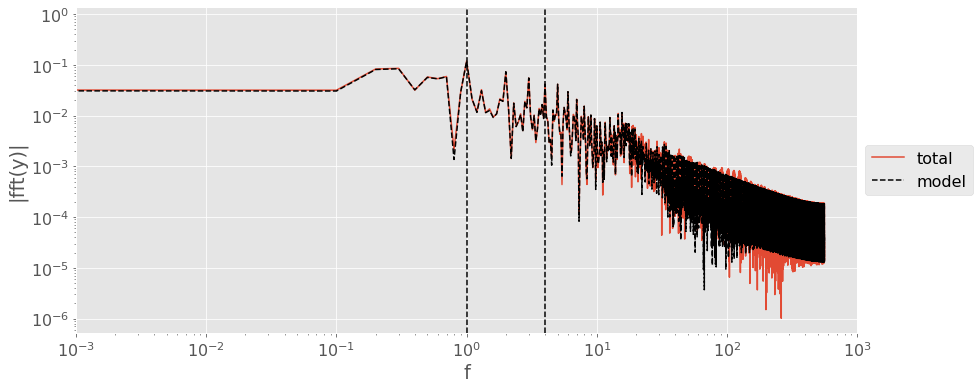

In [37]:
plot_fft(X_train, y_train, model=model_v3, xlim=(1e-3, 1e3), logx=True, logy=True)

# loss landscape

In [19]:
import sys

In [20]:
sys.path.insert(0, "/Users/spx8sk/work/git/landscapeviz")

In [21]:
import landscapeviz

In [39]:
%%time
# 4. build mesh and plot
landscapeviz.build_mesh(model_v3, (X_train, y_train), grid_length=40, verbose=0)

CPU times: user 8min 5s, sys: 58.4 s, total: 9min 3s
Wall time: 4min 56s


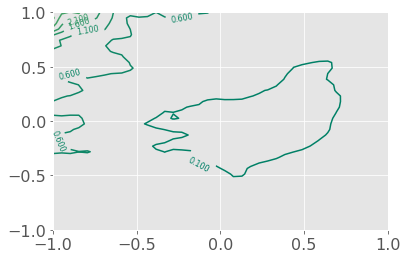

In [40]:
landscapeviz.plot_contour(key="mse")

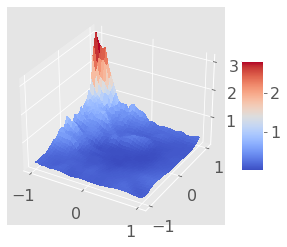

In [41]:
landscapeviz.plot_3d(key="mse")